# Traffic sign recognition using Tensorflow 

For training I am using German sign dataset which can be found here: http://benchmark.ini.rub.de/

In [1]:
import os
import random
import csv
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from keras.preprocessing.image import ImageDataGenerator
import cv2

Using TensorFlow backend.


Setting path to train and test data.

In [2]:
ROOT_PATH = "./datasets"
TRAIN_DATA_DIR = os.path.join(ROOT_PATH, "training_images/Final_Training/Images/")
TEST_DATA_DIR = os.path.join(ROOT_PATH, "testing_dataset/Final_Test/Images/")
IMAGE_WIDTH = 32
IMAGE_LENGTH = 32
BATCH_SIZE = 128

Loading train data.

In [14]:
def load_train_data(data_dir):
    directories = [d for d in os.listdir(data_dir)
                  if os.path.isdir(os.path.join(data_dir, d))]
    labels = []
    images = []
            
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        label_file_names = [os.path.join(label_dir, f)
                        for f in os.listdir(label_dir) if f.endswith(".ppm")]
        
        for image in label_file_names:
            images.append(skimage.transform.resize(plt.imread(image), (IMAGE_WIDTH, IMAGE_LENGTH)))
            labels.append(int(d))
            
    return labels, images

Loading test data.

In [15]:
def load_test_data(data_dir):
    csv_file = open(data_dir + 'GT-final_test.csv')
    
    images = []
    labels = []
    
    reader = csv.reader(csv_file, delimiter=';')
    reader.next()
    for row in reader:
        images.append(skimage.transform.resize(plt.imread(data_dir + row[0]), (IMAGE_WIDTH, IMAGE_LENGTH)))
        labels.append(int(row[7]))
    csv_file.close()
    return labels, images

In [16]:
train_labels, train_images = load_train_data(TRAIN_DATA_DIR)
val_labels, val_images = load_test_data(TEST_DATA_DIR)

In [17]:
train_labels_arr = np.array(train_labels)
train_images_arr = np.array(train_images)

In [18]:
val_labels_arr = np.array(val_labels)
val_images_arr = np.array(val_images)

In [ ]:
datagen = ImageDataGenerator(rotation_range=17,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=False)

In [ ]:
for keras_gen_images, keras_gen_labels in datagen.flow(train_images_arr, train_labels_arr,
                                             batch_size=len(train_labels), shuffle=False):
    break

In [ ]:
def generate_blur_images(train_images):
    blur_images = []

    images_count = len(train_images)

    for i in range(images_count):
        blur_images.append(cv2.GaussianBlur(train_images[i], (5, 5), 0.7))
    
    return np.array(blur_images)

blur_images = generate_blur_images(train_images)

In [ ]:
index = random.sample(xrange(len(train_images_arr)), 9)

In [ ]:
plt.figure(figsize=(6,6))

for i in range(0, 9):
    plt.subplot(331 + i)
    plt.imshow(train_images_arr[index[i]])
plt.savefig('expore_training_data.png')
plt.show()

plt.figure(figsize=(6,6))

for i in range(0, 9):
    plt.subplot(331 + i)
    plt.imshow(keras_gen_images[index[i]])
plt.savefig('expore_keras_data.png')
plt.show()

In [ ]:
train_labels_arr = np.concatenate((train_labels_arr, np.array(train_labels), keras_gen_labels))
train_images_arr = np.concatenate((train_images_arr, blur_images, keras_gen_images))

Creating bar chart for dataset Visualization.

In [ ]:
def draw_data_chart(train_labels, save_name):
    data = np.unique(train_labels_arr, return_counts=True)[1]
   
    plt.figure(figsize=(20, 10))

    y_pos = np.arange(len(data))

    plt.bar(y_pos, data, align='center', alpha = 0.5)
    plt.xticks(y_pos, y_pos)
    plt.axis('tight')
    plt.savefig(save_name)
    plt.show()

In [ ]:
draw_data_chart(train_labels_arr, './chart_figures/train_data.png')
draw_data_chart(val_labels_arr, './chart_figures/test_data.png')

In [5]:
def conv2d(input_layer, filters, padding):
    return tf.layers.conv2d(
        inputs=input_layer,
        filters=filters,
        kernel_size=(5, 5),
        padding=padding,
        activation=tf.nn.elu)

def pooling(input_layer):
    return tf.layers.max_pooling2d(
        inputs=input_layer, 
        pool_size=(2, 2), 
        strides=(2, 2),
        padding='same')

with tf.device('/device:GPU:0'):    
    images = tf.placeholder(tf.float32, [None, IMAGE_WIDTH, IMAGE_LENGTH, 3], name = "images")
    labels = tf.placeholder(tf.int64, [None])
    
    conv1 = conv2d(images, 12, 'valid')
    pool1 = pooling(conv1)
    
    conv2 = conv2d(pool1, 24, 'valid')
    pool2 = pooling(conv2)
    
    flat = tf.layers.flatten(pool2)
    dropout = tf.layers.dropout(inputs=flat, rate=0.5)
    
    dense = tf.layers.dense(dropout, 512, tf.nn.elu)
    
    
    logits = tf.layers.dense(dense, len(set(train_labels_arr)), tf.nn.elu)

    predicted = tf.nn.softmax(logits)
    predicted_labels = tf.argmax(predicted, 1, name="prediction")
    
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,
                                                                   labels = labels)
    loss = tf.reduce_mean(cross_entropy)

    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    correct_prediction = tf.equal(predicted_labels, labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    init = tf.global_variables_initializer()

with tf.device('/cpu:0'):
    confusion_matrix = tf.confusion_matrix(labels=labels, predictions=predicted_labels,
                                          num_classes=len(set(train_labels_arr)),dtype=tf.int64)

NameError: name 'train_labels_arr' is not defined

In [28]:
saver = tf.train.Saver()
session = tf.Session()
session.run(init)

In [21]:
def validation(val_images, val_labels):
    val_acc = session.run(accuracy,
                    {images: val_images,
                    labels: val_labels})
    
    return val_acc

In [22]:
def training_log(steps, loss, val_acc, training_time):
    print('Steps: {}'.format(steps))
    print('Loss: {0} Validation accuracy: {1:.2f}%'
          .format(loss, val_acc * 100))
    minutes, seconds = divmod(training_time, 60)
    hours, minutes = divmod(minutes, 60)
    print('Traning time: {0:02.0f}:{1:02.0f}:{2:05.2f}\n'.format(hours, minutes, seconds))  

In [62]:
def show_confusion_matrix(conf_matrix):
    plt.figure(figsize=(10,10))

    plt.imshow(conf_matrix)
    plt.colorbar()
    #plt.show()

In [ ]:
def draw_graph(training_data):
    steps, loss, accuracy = zip(*training_data)
    fig = plt.figure(figsize=(10,10))
    plt.subplot(211)
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.xlabel('Steps')
    
    plt.plot(steps, loss)
    plt.subplots_adjust(hspace=1)
    
    plt.subplot(212)
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Steps')
    plt.plot(steps, accuracy)
    
    plt.savefig('train_log.png')
    plt.show()

In [27]:
np.set_printoptions(threshold=np.nan)

Steps: 0
Loss: 0.00652692560107 Validation accuracy: 91.40%
Traning time: 00:00:01.42

Steps: 50
Loss: 0.0116662830114 Validation accuracy: 91.66%
Traning time: 00:00:06.75

Steps: 100
Loss: 0.04881554842 Validation accuracy: 92.50%
Traning time: 00:00:11.54



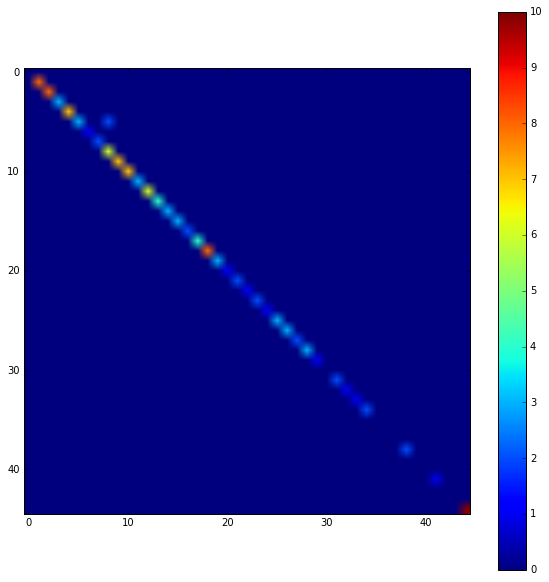

In [63]:
def train_model(training_images, training_labels, val_images, val_labels, steps):
    t_start = time.time()
    prev_val_acc = 0
    prev_loss = 1
    training_data = []
    conf_matrix = []
    for i in range(steps + 1):
        indexes = np.random.choice(np.arange(len(training_images)), BATCH_SIZE, replace = False)
        batch_images = training_images[indexes]
        batch_labels = training_labels[indexes]
        loss_value = session.run([optimizer, loss],
                                 {images: batch_images,
                                 labels: batch_labels})[1]
        conf_matrix = session.run(confusion_matrix,
                                 {images: batch_images,
                                 labels: batch_labels})
        
        if (i % 50 == 0):
            val_acc = validation(val_images, val_labels)
            training_log(i, loss_value, val_acc, time.time() - t_start)
            training_data.append((i, loss_value, val_acc))
            
            if (prev_val_acc < val_acc and prev_loss > loss_value):
                prev_val_acc = val_acc
                prev_loss = loss_value
                saver.save(session, './model2/model')
    show_confusion_matrix(conf_matrix)
    draw_graph(training_data)
          
train_model(train_images_arr, train_labels_arr, val_images_arr, val_labels_arr, 100)

In [25]:
session.close()